In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import style
import pandas as pd
from tqdm.auto import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

DIR = os.getcwd()

Running on the GPU


In [3]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-1f0e1b27-fad9-8a61-0636-4d78f6cf26c4)


In [4]:
print(DIR)

/content


In [5]:
BATCH_SIZE = 64
EPOCHS = 10
PIXELS = 128
nc = 3 # Number of color channels
d_dim = 200 # Length of latent Vector (nz)

In [6]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import json
import requests
import time
import zipfile
import os
from tqdm import tqdm
import spotipy
import re
from spotipy.oauth2 import SpotifyClientCredentials

In [8]:
client_id = 'ed81fe4aba8e41f28536c55f1ecdb7b0'
client_secret = '27b23d5b42f54bc5a13126cf1e812636'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
# The URL of the playlist
playlist_url = 'https://open.spotify.com/playlist/6FKDzNYZ8IW1pvYVF4zUN2?si=d61087039b6f4784'

In [9]:
!mkdir train

mkdir: cannot create directory ‘train’: File exists


In [10]:

# Extract the playlist id from the URL
playlist_id = playlist_url.split('/')[-1].split('?')[0]

# Create the directory for the album covers if it doesn't already exist
os.makedirs('albumcoverimages', exist_ok=True)

# Initialize an empty list to store the data
data = []

# The number of tracks per page
limit = 100

# The initial offset
offset = 0

while True:
    # Get the tracks in the playlist
    results = sp.playlist_items(playlist_id, offset=offset, limit=limit)

    # Break out of the loop if no more tracks are returned
    if not results['items']:
        break

    # Loop over each track in the playlist
    for item in results['items']:
        track = item['track']
        
        # Use the track id as the filename
        track_id = track['id']
        album_cover_path = f"train/{track_id}.jpg"

        # Check if the album cover already exists
        if not os.path.exists(album_cover_path):
            # Get the audio features for the track
            audio_features = sp.audio_features(track['id'])[0]

            # Check if the track has an album cover
            if track['album']['images']:
                # Add the album cover URL to the data
                audio_features['album_cover_url'] = track['album']['images'][0]['url']

                # Save the album cover
                album_cover_response = requests.get(track['album']['images'][0]['url'])
                with open(album_cover_path, 'wb') as f:
                    f.write(album_cover_response.content)
            else:
                audio_features['album_cover_url'] = None

            # Append the data to the list
            data.append(audio_features)

    # Increase the offset by the limit
    offset += limit

# Write the data to a JSON file
with open('playlist_data.json', 'w') as f:
    json.dump(data, f)

In [12]:
!pwd

/content


In [13]:
!mv train gdrive/MyDrive/

In [14]:
import json
jsondata = json.load(open('/content/playlist_data.json'))

print(len(jsondata))

9324


In [18]:
class ImageFolderEX(datasets.ImageFolder):
    def __getitem__(self, index):
        def get_img(index):
            path, label = self.imgs[index]
            try:
                img = self.loader(os.path.join(self.root, path))
            except:
                img = get_img(index + 1)
            return img
        img = get_img(index)
        return self.transform(img) * 2 - 1  # rescale 0 - 1 to -1 - 1

trans = transforms.Compose([
    transforms.Resize((PIXELS, PIXELS), interpolation=2), 
    transforms.ToTensor(), # implicitly normalizes the input to values between 0 - 1.
])

training_data = torch.utils.data.DataLoader(ImageFolderEX(f"/content/gdrive/MyDrive/8kgan", trans), 
	                                          batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=0)
x = next(iter(training_data))

In [19]:

def Data2Img(x):
  new = torch.zeros(x.size(0), PIXELS, PIXELS, 3)
  
  for i in range(x.size(0)):
    new[i] = torch.transpose(torch.transpose(x[i], 0, 1), 1, 2)
  
  return new

# plt.imshow(Data2Img(x)[3])

In [20]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()  

    kernel_size = 4
    padding = 1
    stride = 2
    alpha = 0.2
    size = 4 * 4 * 1024
    
    # https://www.ritchievink.com/blog/2018/07/16/generative-adversarial-networks-in-pytorch-the-distribution-of-art/
    # We take a vector of d_dim -> to length of 4 * 4 * 1024;
    # This will become a 4 x 4 image with 1024 channels, for which we insert into network
    # We blow up the image to 128 x 128 with 3 channels. 

    self.input = nn.Linear(d_dim, size)
    self.net = nn.Sequential(
      nn.BatchNorm2d(1024),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(1024, 512, kernel_size, stride, padding),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(512, 256, kernel_size, stride, padding),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(256, 128, kernel_size, stride, padding),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(alpha),
      nn.ConvTranspose2d(128, 3, kernel_size, stride, padding),
      nn.Tanh()
    )
  
  def forward(self, z):
    x = self.input(z)
    # Note that this outputs an image with values -1 -> 1; we will 
    # need to make sure to scale to 256 after
    return self.net(x.view(-1, 1024, 4, 4))

def GenView():  
  print("Generators's Info")
  genInput = torch.randn(BATCH_SIZE, d_dim)
  print(f"Input Size: {genInput.size()}")
  testGen = Generator()
  output = testGen(genInput)
  print(f"Output Size: {output.size()}")

GenView()

Generators's Info
Input Size: torch.Size([64, 200])
Output Size: torch.Size([64, 3, 128, 128])


In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        kernel_size = 4
        padding = 1
        stride = 2
        alpha = 0.2

        # Note that due to our generators outputs, we will need to make sure real
        # images are scaled properly.
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(alpha),
            nn.Conv2d(256, 512, kernel_size, stride, padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 1024, kernel_size, stride, padding),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(alpha),
        )
        self.output = nn.Linear(4 * 4 * 1024, 1)
        
    def forward(self, x):
        x = self.net(x)
        # The net downsizes 128 x 128 by stride = 2 every layer -> 4 x 4 with 
        # 1024 channels
        x = torch.reshape(x, (-1, 4 * 4 * 1024))
        x = self.output(x)
        
        return x

def DiscView():
  print("Discriminator's Info")
  discInput = torch.randn(BATCH_SIZE, 3, PIXELS, PIXELS)
  print(f"Input Size: {discInput.size()}")
  testDisc = Discriminator()
  output = testDisc(discInput)
  print(f"Output Size: {output.size()}")

DiscView()


Discriminator's Info
Input Size: torch.Size([64, 3, 128, 128])
Output Size: torch.Size([64, 1])


In [22]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device(device))
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    return model

# D = load_checkpoint('./gdrive/MyDrive/wcheckpointD.pth').to(device)
# G = load_checkpoint('./gdrive/MyDrive/wcheckpointG.pth').to(device)

In [23]:
G = Generator().to(device)
D = Discriminator().to(device)

In [24]:
print(G)
print(D)

Generator(
  (input): Linear(in_features=200, out_features=16384, bias=True)
  (net): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, 

In [25]:
# optimizer
lr = 1e-4
beta = (0.0,0.9)

def load_optim(filepath, net, lr,beta):
    checkpoint = torch.load(filepath)
    myOpt = optim.Adam(net.parameters(), lr = lr, betas=beta)
    myOpt.load_state_dict(checkpoint['optimizer'])
    return myOpt

# D_optimizer = load_optim('./gdrive/My Drive/wcheckpointD.pth', D, lr, beta)
# G_optimizer = load_optim('./gdrive/My Drive/wcheckpointG.pth', G, lr, beta)

In [26]:
# optimizer
lr = 1e-4
beta = (0.0,0.9)

G_optimizer = optim.Adam(G.parameters(), lr = lr, betas=beta)
D_optimizer = optim.Adam(D.parameters(), lr = lr, betas=beta)

In [27]:
def gradient_penalty(critic, real, fake, device="cpu"):
  BATCHSIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCHSIZE,1,1,1)).repeat(1,C,H,W).to(device)
  # Interpolating real and fake image with random epsilon per image
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # Calculate critic scores
  mixed_score = D(interpolated_images)

  # Gradient of mixed score in respect to the interpolated images
  gradient = torch.autograd.grad(
      inputs=interpolated_images,
      outputs=mixed_score,
      grad_outputs=torch.ones_like(mixed_score),
      create_graph=True,
      retain_graph=True,
  )[0]

  # Flatten the gradient
  gradient = gradient.view(gradient.shape[0],-1)
  # Take the L2 Norm
  gradient_norm = gradient.norm(2,dim=1)
  gradient_penalty = torch.mean((gradient_norm-1)**2)
  return gradient_penalty

LAMBDA_GP = 10

In [28]:
def D_train(x):
  D_optimizer.zero_grad()

  # Creating inputs of real data
  realX, realY = x.to(device), torch.ones(x.size(0), 1).to(device)
  D_real_output = D(realX)
  
  # Creating inputs of generated data
  z = torch.randn(x.size(0),d_dim).to(device)
  fakeX, fakeY = G(z), torch.zeros(x.size(0), 1).to(device)
  D_fake_output = D(fakeX.detach())
  D_fake_output = D_fake_output.view(x.size(0), 1)
  
  # Gradient Penalty
  gp = gradient_penalty(D,realX, fakeX, device)

  # Take the average
  D_loss = -torch.mean(D_real_output) + torch.mean(D_fake_output) + LAMBDA_GP * gp
  D_loss.backward(retain_graph=True)
  D_optimizer.step()     

  # print("D ", D_loss.item())
  return D_loss.item(), x.size(0)

In [29]:
def G_train(size):
  G_optimizer.zero_grad()

  # Is this consider a random distribution?
  z = torch.randn(size,d_dim).to(device)
  # We want the Discriminator to think this is all real data
  y = torch.ones(size, 1).to(device)

  G_output = G(z)
  D_output = D(G_output)
  D_output = D_output.view(size, 1)
  G_loss = -torch.mean(D_output)
  
  G_loss.backward()
  G_optimizer.step()
  
  # print("G ", G_loss.item())
  return G_loss.item()

In [30]:
def view_G():
  with torch.no_grad():
    test_z = torch.randn(BATCH_SIZE,d_dim).to(device)
    generate = G(test_z)
    return (Data2Img(generate)[0] + 1) / 2

# plt.imshow(view_G())

In [31]:
def save():
  path = "/content/gdrive/MyDrive/" 
  checkpointG = {'model': Generator(),
              'state_dict': G.state_dict(),
              'optimizer' : G_optimizer.state_dict()}
  torch.save(checkpointG, path + 'wcheckpointG_8k.pth')
  checkpointD = {'model': Discriminator(),
              'state_dict': D.state_dict(),
              'optimizer' : D_optimizer.state_dict()}
  torch.save(checkpointD, path + 'wcheckpointD_8k.pth')

def saveArrays():
  # Save the Tracked Data
  path = "/content/gdrive/MyDrive/"
  np.save(path + "d_loss_8k.npy", np.array(epoch_d))
  np.save(path + "g_loss_8k.npy", np.array(epoch_g))

save()

In [32]:
def plotData(d_data, g_data):
  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1), (0,0))
  ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
  
  ax1.plot(range(len(d_data)), d_data, label="Discriminator's Loss")
  ax1.legend(loc=2)
  ax2.plot(range(len(g_data)), g_data, label="Generator's Loss")
  ax2.legend(loc=2)
  plt.xlabel("Training Iteration")
  plt.ylabel("Loss Values")
  
  plt.show()

In [33]:
path = "/content/gdrive/MyDrive/"
# epoch_d = np.load(path + "d_loss.npy", allow_pickle=True)
# epoch_g = np.load(path + "g_loss.npy", allow_pickle=True)
# saveArrays()

In [34]:
epoch_d = np.array([])
epoch_g = np.array([])
saveArrays()

In [35]:
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs Progress"):
  D_losses, G_losses = [], []
  count = 0
  for batch_idx, x in tqdm(enumerate(training_data), desc="Batch Progress"):
    if count == 400:
      count = 0
      epoch_d = np.append(epoch_d, torch.mean(torch.FloatTensor(D_losses[-400:])))
      epoch_g = np.append(epoch_g, torch.mean(torch.FloatTensor(G_losses[-80:])))
      save()
      saveArrays()
    val, size = D_train(x)
    D_losses.append(val) 
    if batch_idx % 5 == 0:
      G_losses.append(G_train(size)) 
    count += 1   
    
  d_mean = torch.mean(torch.FloatTensor(D_losses))
  g_mean = torch.mean(torch.FloatTensor(G_losses))
  epoch_d = np.append(epoch_d, d_mean)
  epoch_g = np.append(epoch_g, g_mean)
  print(f"Epoch: {epoch} | D_loss: {d_mean} | G_loss: {g_mean}")
  save()     
  saveArrays()

Epochs Progress:   0%|          | 0/10 [00:00<?, ?it/s]
Batch Progress: 0it [00:00, ?it/s]
Batch Progress: 1it [00:14, 14.02s/it]
Batch Progress: 2it [00:15,  6.48s/it]
Batch Progress: 3it [00:16,  4.04s/it]
Batch Progress: 4it [00:17,  2.91s/it]
Batch Progress: 5it [00:18,  2.28s/it]
Batch Progress: 6it [00:19,  1.91s/it]
Batch Progress: 7it [00:20,  1.64s/it]
Batch Progress: 8it [00:22,  1.46s/it]
Batch Progress: 9it [00:23,  1.34s/it]
Batch Progress: 10it [00:24,  1.25s/it]
Batch Progress: 11it [00:25,  1.23s/it]
Batch Progress: 12it [00:26,  1.18s/it]
Batch Progress: 13it [00:27,  1.14s/it]
Batch Progress: 14it [00:28,  1.13s/it]
Batch Progress: 15it [00:29,  1.18s/it]
Batch Progress: 16it [00:31,  1.22s/it]
Batch Progress: 17it [00:32,  1.17s/it]
Batch Progress: 18it [00:33,  1.16s/it]
Batch Progress: 19it [00:34,  1.13s/it]
Batch Progress: 20it [00:35,  1.11s/it]
Batch Progress: 21it [00:36,  1.13s/it]
Batch Progress: 22it [00:37,  1.10s/it]
Batch Progress: 23it [00:38,  1.08s/it

Epoch: 1 | D_loss: -82.20028686523438 | G_loss: 46.508785247802734


Epochs Progress:  10%|█         | 1/10 [03:09<28:27, 189.76s/it]
Batch Progress: 0it [00:00, ?it/s]
Batch Progress: 1it [00:01,  1.22s/it]
Batch Progress: 2it [00:02,  1.12s/it]
Batch Progress: 3it [00:03,  1.11s/it]
Batch Progress: 4it [00:04,  1.11s/it]
Batch Progress: 5it [00:05,  1.15s/it]
Batch Progress: 6it [00:06,  1.18s/it]
Batch Progress: 7it [00:08,  1.16s/it]
Batch Progress: 8it [00:09,  1.15s/it]
Batch Progress: 9it [00:10,  1.13s/it]
Batch Progress: 10it [00:11,  1.13s/it]
Batch Progress: 11it [00:12,  1.15s/it]
Batch Progress: 12it [00:13,  1.12s/it]
Batch Progress: 13it [00:14,  1.12s/it]
Batch Progress: 14it [00:15,  1.13s/it]
Batch Progress: 15it [00:17,  1.15s/it]
Batch Progress: 16it [00:18,  1.21s/it]
Batch Progress: 17it [00:19,  1.16s/it]
Batch Progress: 18it [00:20,  1.13s/it]
Batch Progress: 19it [00:21,  1.14s/it]
Batch Progress: 20it [00:22,  1.12s/it]
Batch Progress: 21it [00:24,  1.14s/it]
Batch Progress: 22it [00:25,  1.12s/it]
Batch Progress: 23it [00:26, 

Epoch: 2 | D_loss: -105.9507064819336 | G_loss: 50.917579650878906


Epochs Progress:  20%|██        | 2/10 [06:04<24:08, 181.10s/it]
Batch Progress: 0it [00:00, ?it/s]
Batch Progress: 1it [00:01,  1.20s/it]
Batch Progress: 2it [00:02,  1.12s/it]
Batch Progress: 3it [00:03,  1.09s/it]
Batch Progress: 4it [00:04,  1.11s/it]
Batch Progress: 5it [00:05,  1.13s/it]
Batch Progress: 6it [00:06,  1.18s/it]
Batch Progress: 7it [00:08,  1.17s/it]
Batch Progress: 8it [00:09,  1.14s/it]
Batch Progress: 9it [00:10,  1.14s/it]
Batch Progress: 10it [00:11,  1.13s/it]
Batch Progress: 11it [00:12,  1.15s/it]
Batch Progress: 12it [00:13,  1.13s/it]
Batch Progress: 13it [00:14,  1.12s/it]
Batch Progress: 14it [00:15,  1.13s/it]
Batch Progress: 15it [00:16,  1.11s/it]
Batch Progress: 16it [00:18,  1.17s/it]
Batch Progress: 17it [00:19,  1.19s/it]
Batch Progress: 18it [00:20,  1.20s/it]
Batch Progress: 19it [00:21,  1.17s/it]
Batch Progress: 20it [00:22,  1.15s/it]
Batch Progress: 21it [00:24,  1.15s/it]
Batch Progress: 22it [00:25,  1.12s/it]
Batch Progress: 23it [00:26, 

Epoch: 3 | D_loss: -76.18304443359375 | G_loss: 103.17261505126953


Epochs Progress:  30%|███       | 3/10 [08:59<20:46, 178.04s/it]
Batch Progress: 0it [00:00, ?it/s]
Batch Progress: 1it [00:01,  1.20s/it]
Batch Progress: 2it [00:02,  1.13s/it]
Batch Progress: 3it [00:03,  1.10s/it]
Batch Progress: 4it [00:04,  1.09s/it]
Batch Progress: 5it [00:05,  1.08s/it]
Batch Progress: 6it [00:06,  1.13s/it]
Batch Progress: 7it [00:07,  1.10s/it]
Batch Progress: 8it [00:08,  1.13s/it]
Batch Progress: 9it [00:10,  1.19s/it]
Batch Progress: 10it [00:11,  1.19s/it]
Batch Progress: 11it [00:12,  1.20s/it]
Batch Progress: 12it [00:13,  1.18s/it]
Batch Progress: 13it [00:14,  1.15s/it]
Batch Progress: 14it [00:16,  1.14s/it]
Batch Progress: 15it [00:17,  1.11s/it]
Batch Progress: 16it [00:18,  1.15s/it]
Batch Progress: 17it [00:19,  1.13s/it]
Batch Progress: 18it [00:20,  1.13s/it]
Batch Progress: 19it [00:21,  1.23s/it]
Batch Progress: 20it [00:23,  1.21s/it]
Batch Progress: 21it [00:24,  1.22s/it]
Batch Progress: 22it [00:25,  1.17s/it]
Batch Progress: 23it [00:26, 

Epoch: 4 | D_loss: -84.47777557373047 | G_loss: 121.97123718261719


Epochs Progress:  40%|████      | 4/10 [11:54<17:41, 176.92s/it]
Batch Progress: 0it [00:00, ?it/s]
Batch Progress: 1it [00:01,  1.26s/it]
Batch Progress: 2it [00:02,  1.15s/it]
Batch Progress: 3it [00:03,  1.10s/it]
Batch Progress: 4it [00:04,  1.09s/it]
Batch Progress: 5it [00:05,  1.10s/it]
Batch Progress: 6it [00:06,  1.13s/it]
Batch Progress: 7it [00:07,  1.10s/it]
Batch Progress: 8it [00:08,  1.08s/it]
Batch Progress: 9it [00:09,  1.10s/it]
Batch Progress: 10it [00:11,  1.14s/it]
Batch Progress: 11it [00:12,  1.21s/it]
Batch Progress: 12it [00:13,  1.20s/it]
Batch Progress: 13it [00:14,  1.16s/it]
Batch Progress: 14it [00:15,  1.12s/it]
Batch Progress: 15it [00:16,  1.11s/it]
Batch Progress: 16it [00:18,  1.14s/it]
Batch Progress: 17it [00:19,  1.12s/it]
Batch Progress: 18it [00:20,  1.11s/it]
Batch Progress: 19it [00:21,  1.12s/it]
Batch Progress: 20it [00:22,  1.11s/it]
Batch Progress: 21it [00:23,  1.16s/it]
Batch Progress: 22it [00:25,  1.20s/it]
Batch Progress: 23it [00:26, 

Epoch: 5 | D_loss: -82.24224853515625 | G_loss: 132.4917755126953


Epochs Progress:  50%|█████     | 5/10 [14:48<14:38, 175.75s/it]
Batch Progress: 0it [00:00, ?it/s]
Batch Progress: 1it [00:01,  1.19s/it]
Batch Progress: 2it [00:02,  1.14s/it]
Batch Progress: 3it [00:03,  1.19s/it]
Batch Progress: 4it [00:04,  1.15s/it]
Batch Progress: 5it [00:05,  1.12s/it]
Batch Progress: 6it [00:06,  1.14s/it]
Batch Progress: 7it [00:07,  1.11s/it]
Batch Progress: 8it [00:08,  1.09s/it]
Batch Progress: 9it [00:10,  1.10s/it]
Batch Progress: 10it [00:11,  1.10s/it]
Batch Progress: 11it [00:12,  1.13s/it]
Batch Progress: 12it [00:13,  1.12s/it]
Batch Progress: 13it [00:14,  1.22s/it]
Batch Progress: 14it [00:16,  1.23s/it]
Batch Progress: 15it [00:17,  1.19s/it]
Batch Progress: 16it [00:18,  1.19s/it]
Batch Progress: 17it [00:19,  1.17s/it]
Batch Progress: 18it [00:20,  1.15s/it]
Batch Progress: 19it [00:21,  1.13s/it]
Batch Progress: 20it [00:22,  1.11s/it]
Batch Progress: 21it [00:23,  1.13s/it]
Batch Progress: 22it [00:25,  1.11s/it]
Batch Progress: 23it [00:26, 

Epoch: 6 | D_loss: -80.95004272460938 | G_loss: 132.13426208496094


Epochs Progress:  60%|██████    | 6/10 [17:41<11:39, 174.98s/it]
Batch Progress: 0it [00:00, ?it/s]
Batch Progress: 1it [00:01,  1.18s/it]
Batch Progress: 2it [00:02,  1.12s/it]
Batch Progress: 3it [00:03,  1.10s/it]
Batch Progress: 4it [00:04,  1.08s/it]
Batch Progress: 5it [00:05,  1.10s/it]
Batch Progress: 6it [00:06,  1.14s/it]
Batch Progress: 7it [00:07,  1.12s/it]
Batch Progress: 8it [00:08,  1.10s/it]
Batch Progress: 9it [00:10,  1.11s/it]
Batch Progress: 10it [00:11,  1.11s/it]
Batch Progress: 11it [00:12,  1.15s/it]
Batch Progress: 12it [00:13,  1.14s/it]
Batch Progress: 13it [00:14,  1.12s/it]
Batch Progress: 14it [00:15,  1.13s/it]
Batch Progress: 15it [00:16,  1.11s/it]
Batch Progress: 16it [00:18,  1.17s/it]
Batch Progress: 17it [00:19,  1.18s/it]
Batch Progress: 18it [00:20,  1.18s/it]
Batch Progress: 19it [00:21,  1.16s/it]
Batch Progress: 20it [00:22,  1.14s/it]
Batch Progress: 21it [00:23,  1.16s/it]
Batch Progress: 22it [00:24,  1.12s/it]
Batch Progress: 23it [00:25, 

Epoch: 7 | D_loss: -79.89717102050781 | G_loss: 147.14414978027344


Epochs Progress:  70%|███████   | 7/10 [20:36<08:45, 175.04s/it]
Batch Progress: 0it [00:00, ?it/s]
Batch Progress: 1it [00:01,  1.17s/it]
Batch Progress: 2it [00:02,  1.12s/it]
Batch Progress: 3it [00:03,  1.08s/it]
Batch Progress: 4it [00:04,  1.09s/it]
Batch Progress: 5it [00:05,  1.07s/it]
Batch Progress: 6it [00:06,  1.11s/it]
Batch Progress: 7it [00:07,  1.12s/it]
Batch Progress: 8it [00:09,  1.21s/it]
Batch Progress: 9it [00:10,  1.20s/it]
Batch Progress: 10it [00:11,  1.18s/it]
Batch Progress: 11it [00:12,  1.19s/it]
Batch Progress: 12it [00:13,  1.16s/it]
Batch Progress: 13it [00:14,  1.12s/it]
Batch Progress: 14it [00:15,  1.10s/it]
Batch Progress: 15it [00:16,  1.11s/it]
Batch Progress: 16it [00:18,  1.14s/it]
Batch Progress: 17it [00:19,  1.13s/it]
Batch Progress: 18it [00:20,  1.14s/it]
Batch Progress: 19it [00:21,  1.14s/it]
Batch Progress: 20it [00:22,  1.14s/it]
Batch Progress: 21it [00:23,  1.16s/it]
Batch Progress: 22it [00:25,  1.13s/it]
Batch Progress: 23it [00:26, 

Epoch: 8 | D_loss: -80.82416534423828 | G_loss: 144.4568328857422


Epochs Progress:  80%|████████  | 8/10 [23:30<05:49, 174.73s/it]
Batch Progress: 0it [00:00, ?it/s]
Batch Progress: 1it [00:01,  1.27s/it]
Batch Progress: 2it [00:02,  1.14s/it]
Batch Progress: 3it [00:03,  1.11s/it]
Batch Progress: 4it [00:04,  1.09s/it]
Batch Progress: 5it [00:05,  1.08s/it]
Batch Progress: 6it [00:06,  1.17s/it]
Batch Progress: 7it [00:07,  1.12s/it]
Batch Progress: 8it [00:08,  1.11s/it]
Batch Progress: 9it [00:10,  1.12s/it]
Batch Progress: 10it [00:11,  1.13s/it]
Batch Progress: 11it [00:12,  1.23s/it]
Batch Progress: 12it [00:13,  1.25s/it]
Batch Progress: 13it [00:15,  1.21s/it]
Batch Progress: 14it [00:16,  1.16s/it]
Batch Progress: 15it [00:17,  1.15s/it]
Batch Progress: 16it [00:18,  1.18s/it]
Batch Progress: 17it [00:19,  1.16s/it]
Batch Progress: 18it [00:20,  1.15s/it]
Batch Progress: 19it [00:21,  1.14s/it]
Batch Progress: 20it [00:22,  1.13s/it]
Batch Progress: 21it [00:24,  1.16s/it]
Batch Progress: 22it [00:25,  1.24s/it]
Batch Progress: 23it [00:26, 

Epoch: 9 | D_loss: -77.73358154296875 | G_loss: 149.0263214111328


Epochs Progress:  90%|█████████ | 9/10 [26:27<02:55, 175.21s/it]
Batch Progress: 0it [00:00, ?it/s]
Batch Progress: 1it [00:01,  1.48s/it]
Batch Progress: 2it [00:02,  1.31s/it]
Batch Progress: 3it [00:03,  1.20s/it]
Batch Progress: 4it [00:04,  1.14s/it]
Batch Progress: 5it [00:05,  1.10s/it]
Batch Progress: 6it [00:06,  1.12s/it]
Batch Progress: 7it [00:08,  1.10s/it]
Batch Progress: 8it [00:09,  1.10s/it]
Batch Progress: 9it [00:10,  1.10s/it]
Batch Progress: 10it [00:11,  1.10s/it]
Batch Progress: 11it [00:12,  1.14s/it]
Batch Progress: 12it [00:13,  1.22s/it]
Batch Progress: 13it [00:15,  1.21s/it]
Batch Progress: 14it [00:16,  1.17s/it]
Batch Progress: 15it [00:17,  1.16s/it]
Batch Progress: 16it [00:18,  1.18s/it]
Batch Progress: 17it [00:19,  1.16s/it]
Batch Progress: 18it [00:20,  1.13s/it]
Batch Progress: 19it [00:21,  1.11s/it]
Batch Progress: 20it [00:22,  1.09s/it]
Batch Progress: 21it [00:24,  1.13s/it]
Batch Progress: 22it [00:25,  1.11s/it]
Batch Progress: 23it [00:26, 

Epoch: 10 | D_loss: -78.21571350097656 | G_loss: 152.70199584960938


Epochs Progress: 100%|██████████| 10/10 [29:21<00:00, 176.12s/it]


10
10


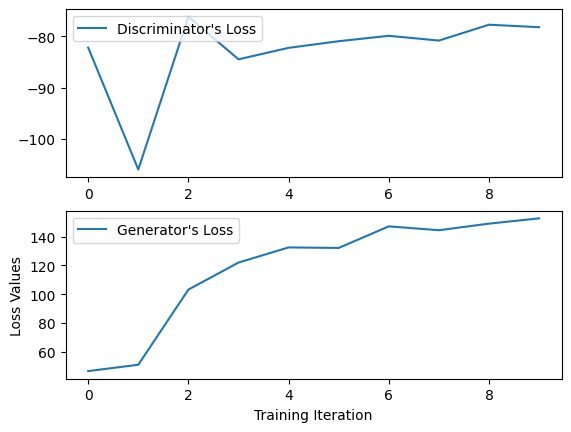

In [36]:

print(len(epoch_d))
print(len(epoch_g))
plotData(epoch_d, epoch_g)

Drawing Generated Images: 100%|██████████| 16/16 [00:00<00:00, 66.75it/s]


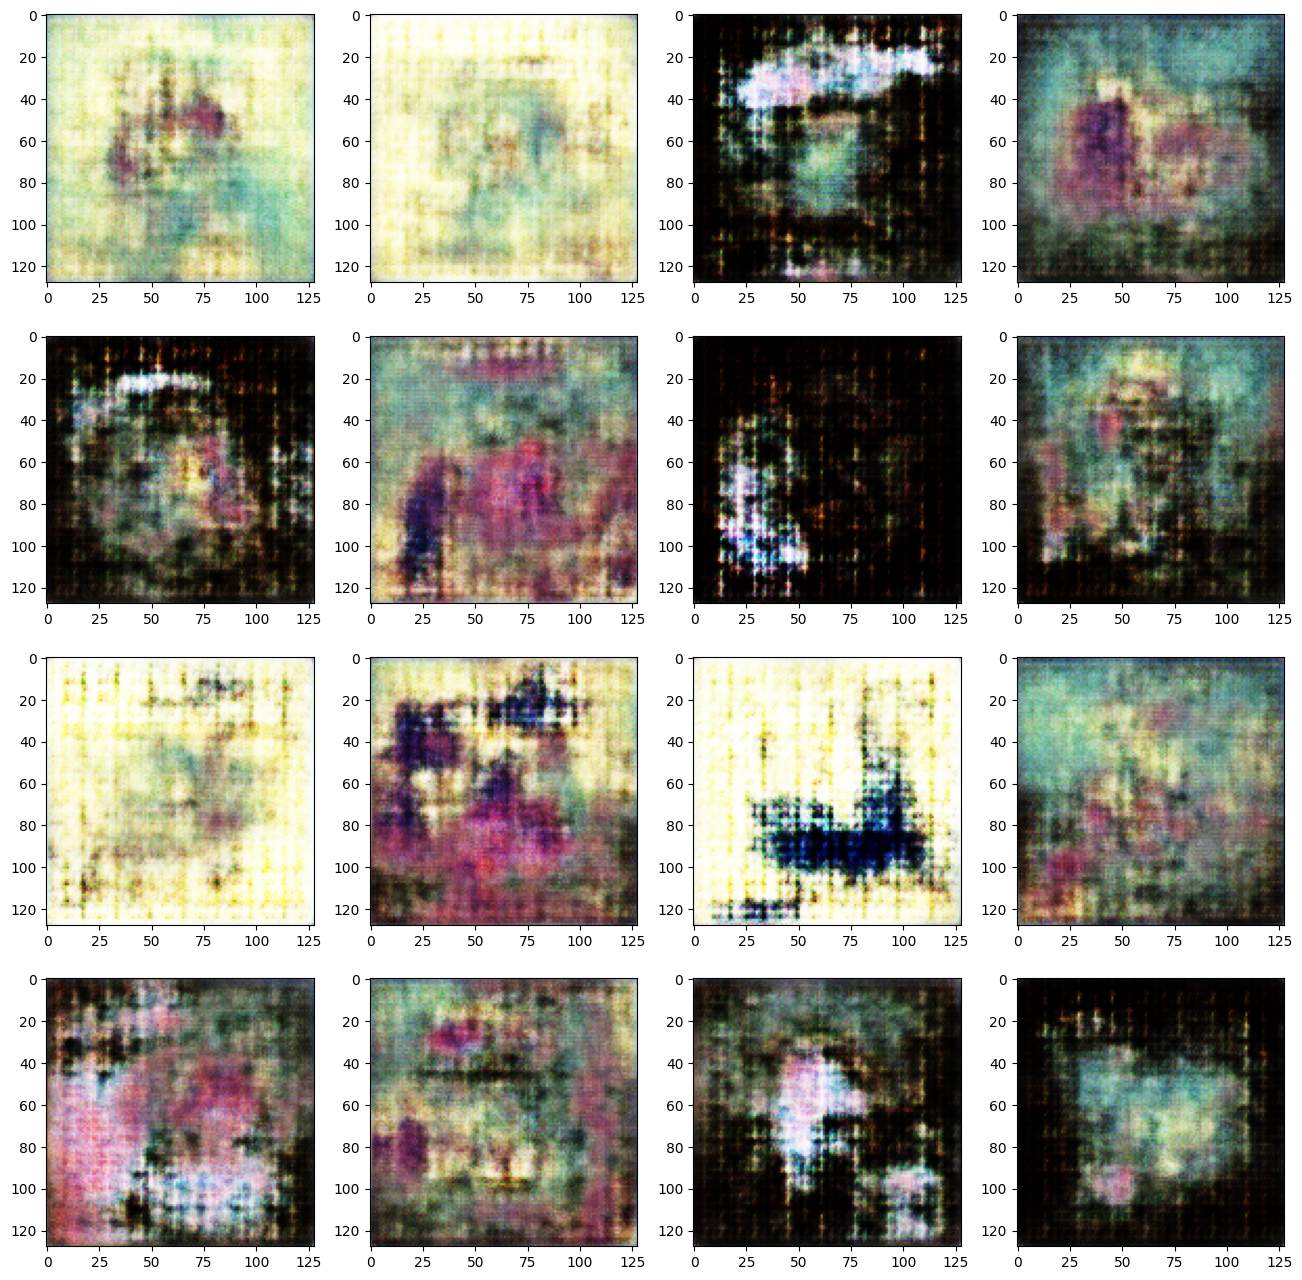

In [38]:

def sampleData():
  lister = []
  for i in range(16):
    lister.append(view_G())
  return lister
 
sample = sampleData()
fig=plt.figure(figsize=(16,16)) 
columns = 4 
rows = 4
for i in tqdm(range(1, columns*rows +1), desc="Drawing Generated Images"):
    fig.add_subplot(rows, columns, i)
    plt.imshow(sample[i-1])  
plt.show()